# Cross-Device Federated Unsupervised Learning of Electrocardiogram Signals

This is the analysis script of the results of the federated learning and on-device fine-tuning (personalized) routines exported from the mobile devices to the results folder.

In [9]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## 1. Loading of the Data

In [10]:
pd.set_option('future.no_silent_downcasting', True)

In [11]:
def load_results(path, standardize=True):
    
    df = pd.DataFrame()
    
    for file in glob.glob(path + "*.csv"):
        temp = pd.read_csv(file, header=None)
        temp.columns = ["segment", "quality", "groundtruth", "residual", "embedding"]
        temp["device"] = file.rsplit('/', 1)[-1][:-4]

        temp_ = temp['embedding'].str.split(';', expand=True)
        col_names_embedding = [f'lvsd_{i+1}' for i in range(temp_.shape[1])]
    
        temp_.columns = col_names_embedding
        temp_ = temp_.astype(float)
    
        temp = pd.concat([temp, temp_], axis=1)
        temp = temp.drop('embedding', axis=1)
        
        group_means = temp.groupby('device')[col_names_embedding].transform('mean')
        temp['euclidean_distance'] = np.sqrt(((temp[col_names_embedding] - group_means) ** 2).sum(axis=1))
    
        if standardize:
            # standardize the data on a subject basis
            temp.residual = (temp.residual - temp.residual.mean()) / temp.residual.mean()
            temp.euclidean_distance = (temp.euclidean_distance - temp.euclidean_distance.mean()) / temp.euclidean_distance.mean()
            
        df = pd.concat([df, temp])

    df.groundtruth = df.groundtruth.replace({"Normal": 0, "PAC": 1, "PVC": 2})
    df.reset_index(inplace=True, drop=True)
    
    return df

In [12]:
df_federated = load_results("./results/federated/")
df_personalized = load_results("./results/personalized/")

In [13]:
df_personalized.head()

,segment,quality,groundtruth,residual,device,lvsd_1,lvsd_2,lvsd_3,lvsd_4,lvsd_5,lvsd_6,lvsd_7,lvsd_8,lvsd_9,lvsd_10,lvsd_11,lvsd_12,euclidean_distance
0,251B8FE6-0D4B-4B92-9F1C-A77C614928A5,excellent,0,-0.409194,device_7_ecg_data,3.937496,2.858460,1.933246,2.725968,1.231919,2.055183,3.471871,0.381866,2.241646,-4.211947,-3.091134,-0.205749,-0.045239
1,251B8FE6-0D4B-4B92-9F1C-A77C614928A5,excellent,0,0.570988,device_7_ecg_data,3.633666,2.562769,2.626094,2.680141,0.464757,0.990130,4.544833,1.287852,2.520912,-4.190048,-3.307577,-0.215481,0.109794
2,251B8FE6-0D4B-4B92-9F1C-A77C614928A5,excellent,0,-0.366211,device_7_ecg_data,3.177270,2.871894,2.006482,3.189815,1.746334,2.610630,3.670957,-0.099036,2.641314,-3.581218,-3.009288,-0.336873,-0.132288
3,251B8FE6-0D4B-4B92-9F1C-A77C614928A5,excellent,0,-0.257489,device_7_ecg_data,2.771319,3.068176,2.416374,3.001668,1.201056,3.282478,2.417229,-0.108962,2.858124,-3.062771,-2.592741,-0.862997,-0.325108
4,251B8FE6-0D4B-4B92-9F1C-A77C614928A5,excellent,0,-0.055216,device_7_ecg_data,3.132269,3.052713,2.269118,2.731179,1.703431,2.219794,3.434719,0.079057,2.413258,-3.831582,-3.656070,-0.669890,-0.013349


## 2. Data Insights

In [ ]:
def plot_embedding_space(df, label="groundtruth", method="pca", path="./media/embedding.png", fontsize=10):
    from sklearn.manifold import TSNE
    
    col_names_embedding = [f'lvsd_{i+1}' for i in range(12)]
    X = df[col_names_embedding].values
    color = df[label]

    num_samples = 50000
    row_indices = np.random.choice(X.shape[0], num_samples, replace=True)
    X = X[row_indices, :]
    if method == "tsne":
        algo = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
    else:
        algo = PCA(n_components=2)

    X_emb = algo.fit_transform(X)
    X_emb = pd.DataFrame(X_emb, columns=["A1", "A2"])
    X_emb["label"] = color.values[row_indices]
    
    # Plotting
    plt.figure(figsize=(5, 5))
    palette = sns.color_palette("tab20", len(df[label].unique()))
    sns.scatterplot(data=X_emb, x="A1", y="A2", hue="label", palette=palette, s=2, legend=False)
    
    # Increase fontsize of axis labels
    plt.xlabel("First Embedding Axis", fontsize=fontsize)
    plt.ylabel("Second Embedding Axis", fontsize=fontsize)
    
    # Increase fontsize of ticks
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    # Save the figure
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()

In [14]:
table = pd.pivot_table(df_federated, values='quality', index=['device'], columns=['groundtruth'], aggfunc="count")

In [15]:
table

groundtruth,0,1,2
device,,,
device_10_ecg_data,95503.0,7.0,1.0
device_11_ecg_data,197539.0,4.0,2.0
device_12_ecg_data,175386.0,982.0,2.0
device_13_ecg_data,136708.0,19.0,75.0
device_14_ecg_data,138504.0,36.0,1.0
device_15_ecg_data,158043.0,129.0,16571.0
device_16_ecg_data,244446.0,26.0,NaN
device_17_ecg_data,196265.0,107.0,46.0
device_18_ecg_data,290193.0,21471.0,228.0


In [16]:
print("Total ECG segments", "- Personalized:", len(df_personalized), "- Federated:", len(df_federated))
print("ECG segments normal", "- Personalized:", len(df_personalized[df_personalized.groundtruth == 0]), "- Federated:", len(df_federated[df_federated.groundtruth == 0]))
print("ECG segments PAC", "- Personalized:", len(df_personalized[df_personalized.groundtruth == 1]), "- Federated:", len(df_federated[df_federated.groundtruth == 1]))
print("ECG segments PVC", "- Personalized:", len(df_personalized[df_personalized.groundtruth == 2]), "- Federated:", len(df_federated[df_federated.groundtruth == 2]))
print("ECG segments medium quality", "- Personalized:", len(df_personalized[df_personalized.quality == "medium"]), "- Federated:", len(df_federated[df_federated.quality == "medium"]))
print("ECG segments excellent quality", "- Personalized:", len(df_personalized[df_personalized.quality == "excellent"]), "- Federated:", len(df_federated[df_federated.quality == "excellent"]))

Total ECG segments - Personalized: 3724041 - Federated: 3724041
ECG segments normal - Personalized: 3664192 - Federated: 3664192
ECG segments PAC - Personalized: 42158 - Federated: 42158
ECG segments PVC - Personalized: 17691 - Federated: 17691
ECG segments medium quality - Personalized: 1377184 - Federated: 1377184
ECG segments excellent quality - Personalized: 2346857 - Federated: 2346857


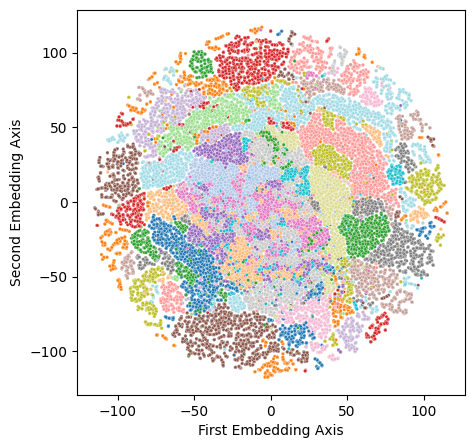

In [43]:
plot_embedding_space(df_personalized.dropna(), label="device", method="tsne")

## 3. Anomaly Detection

In [17]:
def detect_anomalies(df, lvs_dim=12):

    col_names_embedding = [f'lvsd_{i+1}' for i in range(lvs_dim)]
    
    y = df.dropna().groundtruth > 0
    pred = df.dropna().euclidean_distance.abs() + df.dropna().residual
    
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)

    distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
    best_index = np.argmin(distances)
    best_threshold = thresholds[best_index]

    print("Best threshold:", best_threshold)

    return best_threshold

In [40]:
def plot_roc_curve_comparison(df_federated, df_personalized, device=None, fontsize=12, path="./media/roc_curve_comparison.png"):
    plt.figure(figsize=(5,5)).clf()

    if device != None:
        df_federated = df_federated[df_federated.device == device]
        df_personalized = df_personalized[df_personalized.device == device]

    y = df_federated.dropna().groundtruth > 0
    pred = df_federated.dropna().residual
    fpr, tpr, thresh = metrics.roc_curve(y, pred)
    auc = metrics.roc_auc_score(y, pred)
    plt.plot(fpr, tpr, label="Federated Res (AUC=" + str(np.round(auc, 2)) + ")")

    
    y = df_federated.dropna().groundtruth > 0
    pred = df_federated.dropna().euclidean_distance.abs() + df_federated.dropna().residual
    fpr, tpr, thresh = metrics.roc_curve(y, pred)
    auc = metrics.roc_auc_score(y, pred)
    plt.plot(fpr, tpr, label="Federated ResEmb (AUC=" + str(np.round(auc, 2)) + ")")

    y = df_personalized.dropna().groundtruth > 0
    pred = df_personalized.dropna().residual
    fpr, tpr, thresh = metrics.roc_curve(y, pred)
    auc = metrics.roc_auc_score(y, pred)
    plt.plot(fpr, tpr, label="Fine-tuned Res (AUC=" + str(np.round(auc, 2)) + ")")
    
    y = df_personalized.dropna().groundtruth > 0
    pred = df_personalized.dropna().euclidean_distance.abs() + df_personalized.dropna().residual
    fpr, tpr, thresh = metrics.roc_curve(y, pred)
    auc = metrics.roc_auc_score(y, pred)
    plt.plot(fpr, tpr, label="Fine-tuned ResEmb (AUC=" + str(np.round(auc, 2)) + ")")

    # Adding labels and title
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    #plt.title('ROC Curve Comparison', fontsize=fontsize + 2)
    plt.legend(loc=0, fontsize=fontsize)

    # Increase fontsize of ticks
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    # Save the plot
    plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

In [ ]:
def plot_confusion_matrix(df, threshold, fontsize=14, path="./media/confusion_matrix.png"):
    
    y_pred = df.residual + df.euclidean_distance.abs() > threshold
    y_true = df.groundtruth > 0
    df['prediction'] = y_pred
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    custom_labels = ['Normal', 'Anomaly']
    plt.figure(figsize=(5, 5))
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=custom_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=fontsize)
    
    # Increase fontsize of axis labels and ticks
    plt.xlabel('Predicted Label', fontsize=fontsize)
    plt.ylabel('True Label', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    # Increase fontsize of the text inside the confusion matrix
    for text in disp.text_.ravel():
        text.set_fontsize(fontsize)
    
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    
    # Optionally, print out F1-score, specificity, and sensitivity
    f1_score = metrics.f1_score(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    
    print(f'F1 Score: {f1_score:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Sensitivity: {sensitivity:.2f}')
    
    TN, FP, FN, TP = cm.ravel()

    # Calculate Precision and Recall
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    # Calculate F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Calculate Specificity
    specificity = TN / (TN + FP)
    
    print(f'Precision: {precision:.2f}')
    print(f'Recall (Sensitivity): {recall:.2f}')
    print(f'F1 Score: {f1_score:.2f}')
    print(f'Specificity: {specificity:.2f}')
    
    return df

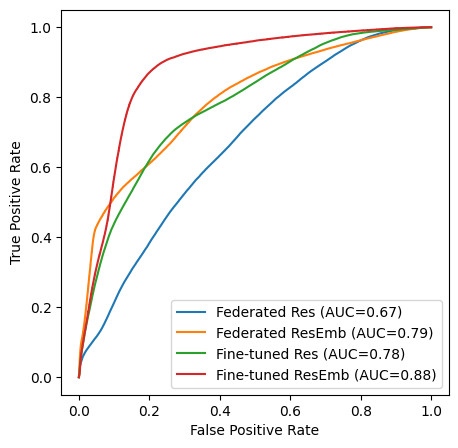

In [41]:
plot_roc_curve_comparison(df_federated, df_personalized, fontsize=10)

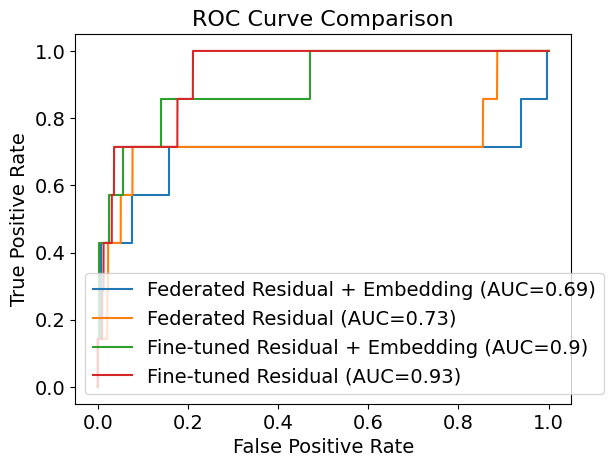

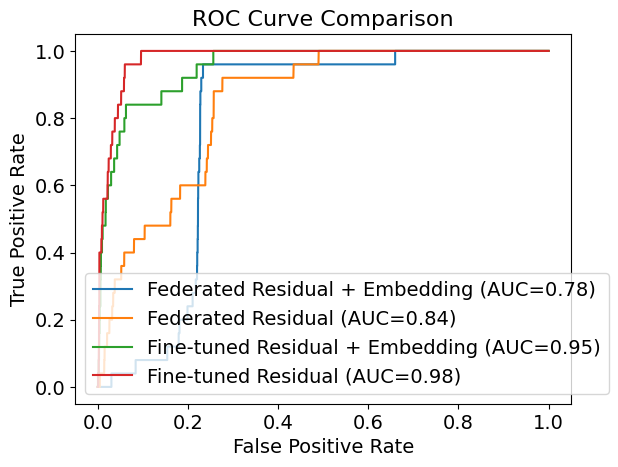

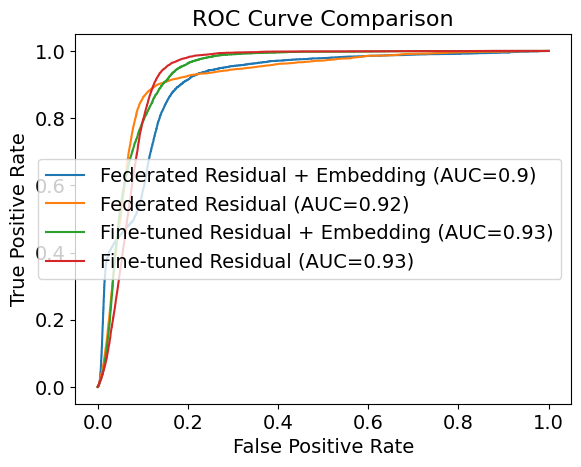

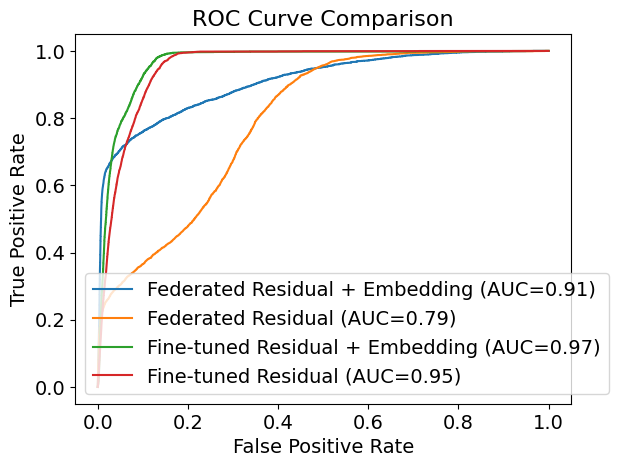

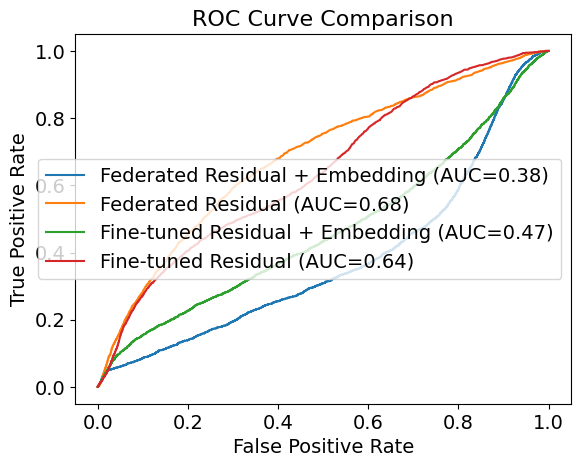

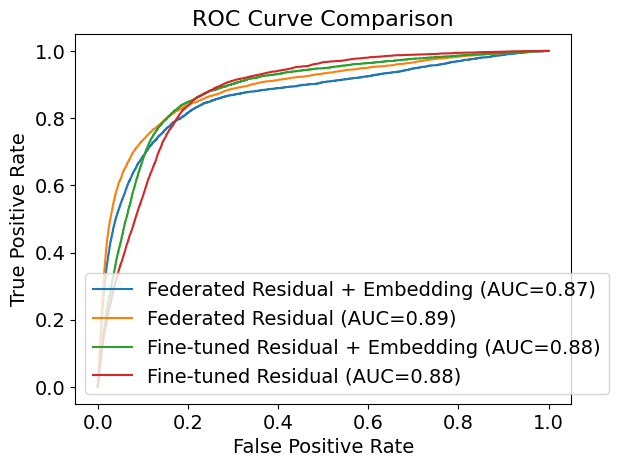

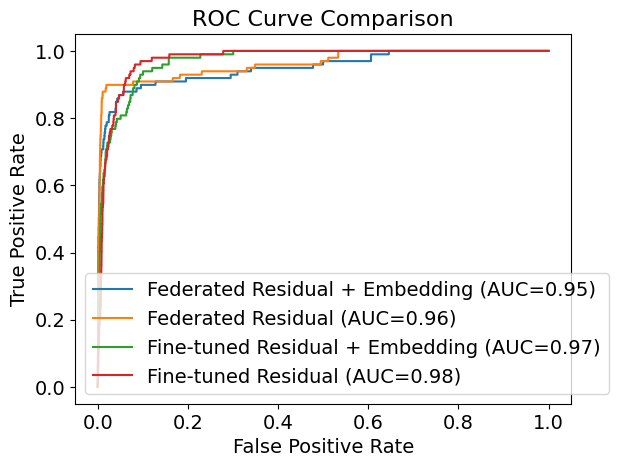

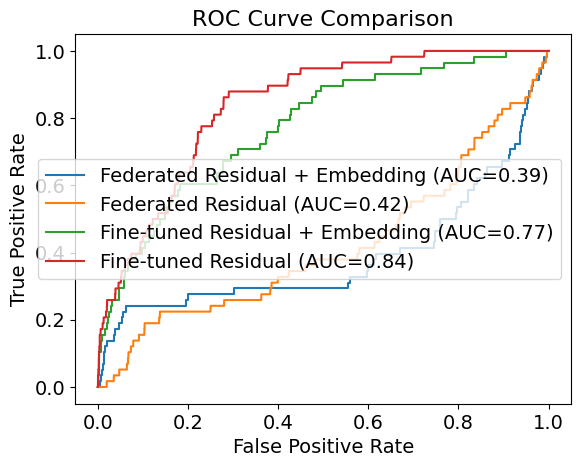

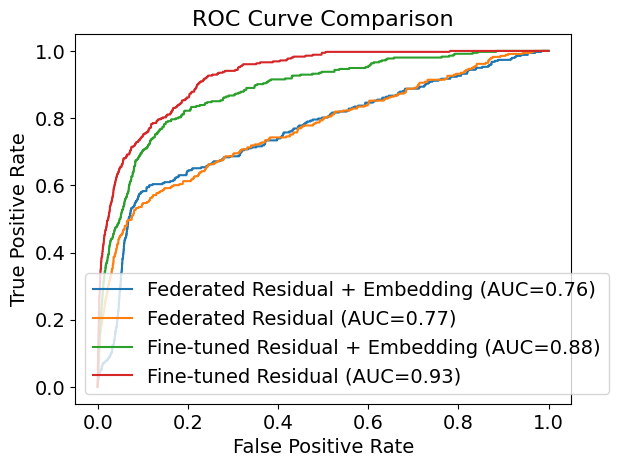

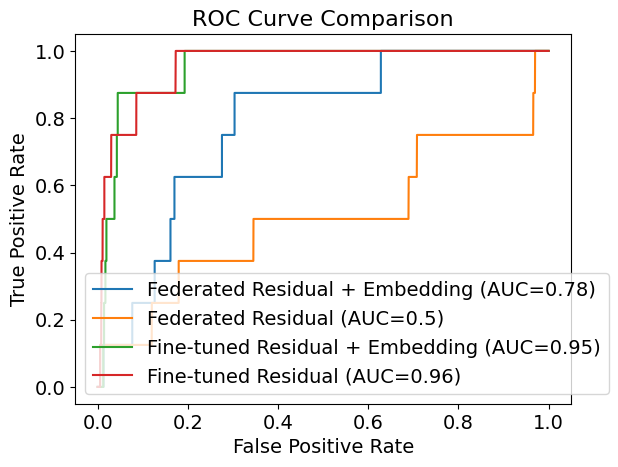

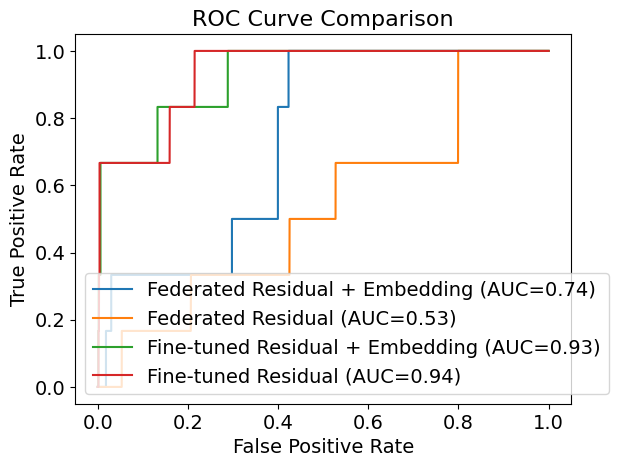

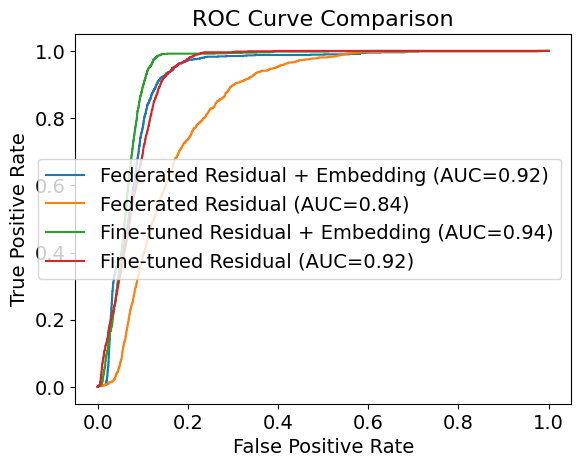

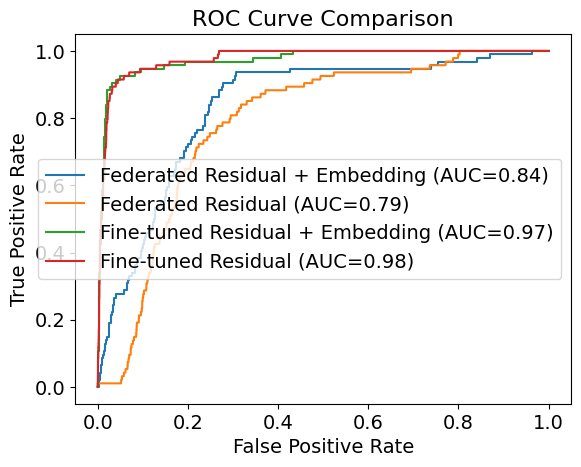

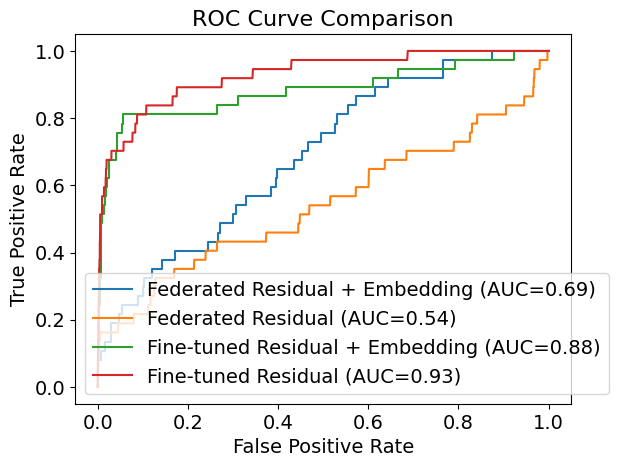

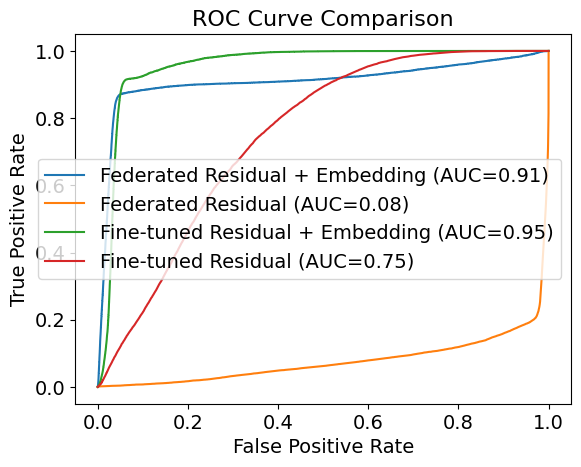

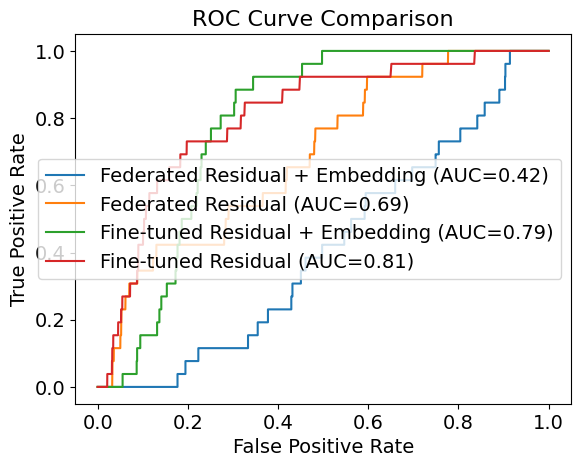

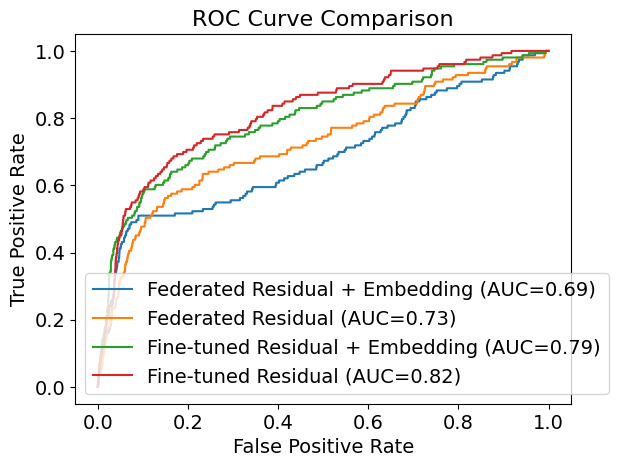

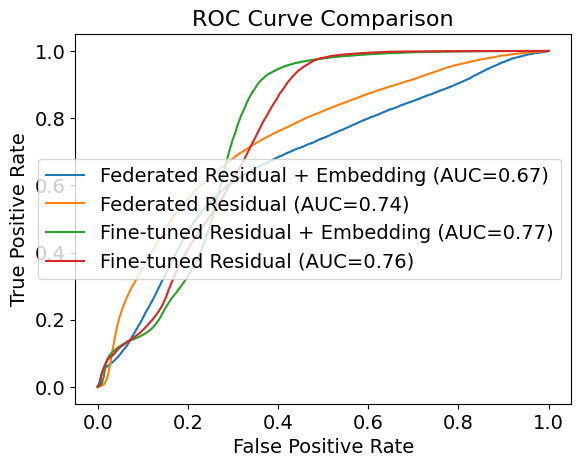

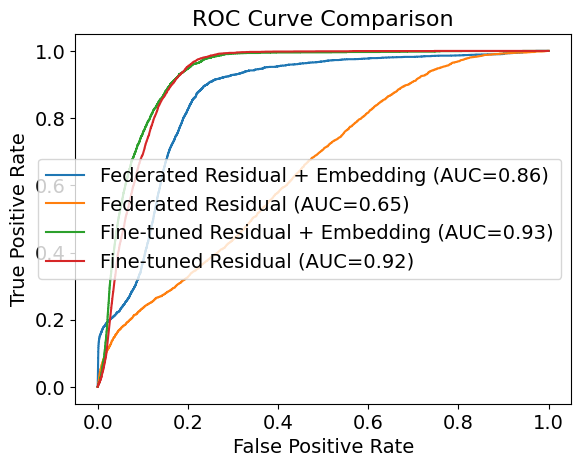

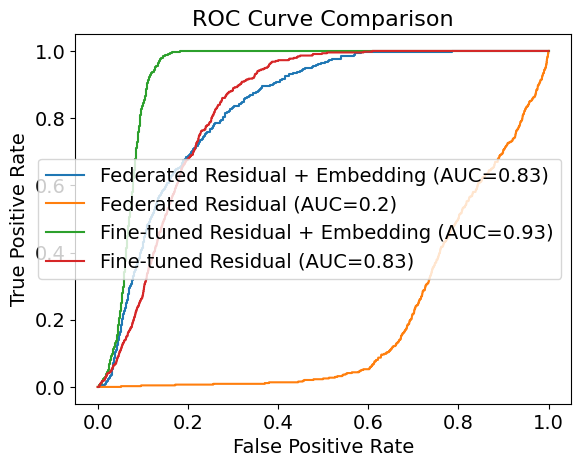

In [14]:
for k in range(1, 21):
    device = f"device_{k}_ecg_data"
    plot_roc_curve_comparison(df_federated, df_personalized, device=device, fontsize=14)

In [18]:
best_threshold_personalized = detect_anomalies(df_personalized)

Best threshold: 0.5005196407620536


In [ ]:
df = plot_confusion_matrix(df_personalized, best_threshold_personalized)

In [ ]:
#PAC
df_pac = df_personalized.loc[df_personalized.groundtruth != 2, :].reset_index(drop=True)
path = "./media/confusion_matrix_pac.png"
_ = plot_confusion_matrix(df_pac, best_threshold_personalized, path=path)

In [ ]:
# PVC
df_pvc = df_personalized.loc[df_personalized.groundtruth != 1, :].reset_index(drop=True)
path = "./media/confusion_matrix_pvc.png"
_ = plot_confusion_matrix(df_pvc, best_threshold_personalized, path=path)

In [ ]:
for k in range(1, 21):
    device = f"device_{k}_ecg_data"
    best_threshold_personalized = detect_anomalies(df_personalized[df_personalized.device==device].dropna())
    path = "./media/confusion" + device + ".png"
    df_device = df_personalized.loc[df_personalized.device==device, :].reset_index(drop=True)
    _ = plot_confusion_matrix(df_device, best_threshold_personalized, path=path)

## 4. Appendix

### 4.1. Federated Model

Loading the weights from the federated learning process to either make predictions on ECG data or to sample ECGs from the latent vector space (though no variational autoencoders). 

In [19]:
import torch
from io import BytesIO
from autoencoder import AE
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Load weights and transform them into a numpy array to inject them into the shared autoencoder model.

In [20]:
path_weights = "../src/federated/weights/round-250-weights.npz"
data = np.load(path_weights, allow_pickle=True)
parameters_serialized = data['arr_0'].item()
pretrained_weights = [np.load(BytesIO(tensor), allow_pickle=False) for tensor in parameters_serialized.tensors]

In [21]:
model = AE()
with torch.no_grad():
    for k, name in enumerate(model.named_parameters()):
        if k % 2 == 0:
            param = name[1]
            param.copy_(torch.from_numpy(pretrained_weights[int(k/2)]))

The reconstructed samples of the autoencoder optimized by the federated learning routine tend to be noisy. Therefore, we introduce a simple smoothing function.

In [22]:
def moving_average(signal, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(signal, window, 'same')

Systematically toggling the values in the latent vector space is used to analyze the change in the reconstruction and thus possibly give the dimensions an interpretation.

In [23]:
def f(val, dim):
    # a randomly chosen encoding from the df_personalized dataframe
    embedding = [0.97, -1.57, 3.55, 3.67, -1.82, 3.61, -0.53, -2.51, 4.461, 2.12, 4.73, -0.74]
    my_tensor = torch.tensor(embedding, dtype=torch.float32)
    my_tensor[dim] = val
    reconstruction = moving_average(model.decoder(my_tensor).detach().numpy(), 10)
    plt.plot(reconstruction)

In [24]:
floatSlider = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0)

In [25]:
interact(f, val=floatSlider, dim=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=0.0, description='val', max=10.0, min=-10.0), Dropdown(description='di…

<function __main__.f(val, dim)>

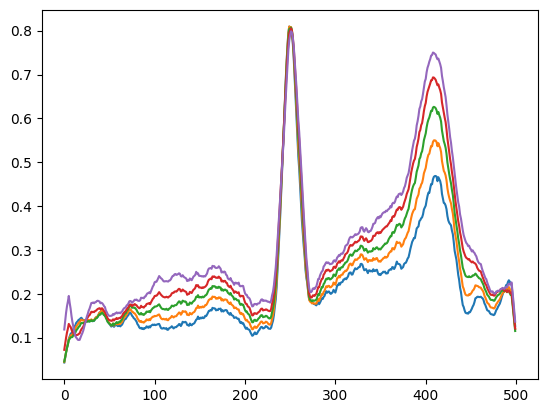

In [26]:
embedding = [0.97, -1.57, 3.55, 3.67, -1.82, 3.61, -0.53, -2.51, 4.461, 2.12, 4.73, -0.74]
     
my_tensor = torch.tensor(embedding, dtype=torch.float32)
lvs_dim = 1
for k in range(lvs_dim, (lvs_dim+1)):
    for j in np.linspace(-2, 2, 5):
        my_tensor[k] = j
        # apply a smoothin operation to gain denoised signals
        recpnstruction = moving_average(model.decoder(my_tensor).detach().numpy(), 10)
        plt.plot(recpnstruction)

### 4.2. Sample Data Plot

To include a visual data example in the respective article, a suitable example is loaded from the Icentia11k dataset and the three relevant label classes (normal, PAC, PVC) and the corresponding ECGs are plotted.

In [27]:
# this sample needs to be downloaded manually
df_plot = pd.read_csv("./sample/p03984_24.csv")

In [28]:
index_pac = df_plot[df_plot.annotation == "pac"].index
index_pvc = df_plot[df_plot.annotation == "pvc"].index
index_normal = df_plot[df_plot.annotation == "normal"].index

In [29]:
values_pac = df_plot.iloc[(index_pac[2]-125):(index_pac[2]+125), 0].reset_index(drop=True).reset_index()
values_pvc = df_plot.iloc[(index_pvc[2]-125):(index_pvc[2]+125), 0].reset_index(drop=True).reset_index()
values_normal = df_plot.iloc[(index_normal[2]-125):(index_normal[2]+125), 0].reset_index(drop=True).reset_index()

In [30]:
values_pac["annotation"] = "PAC"
values_pvc["annotation"] = "PVC"
values_normal["annotation"] = "Normal"

In [31]:
values = pd.concat([values_pac, values_pvc, values_normal])

/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


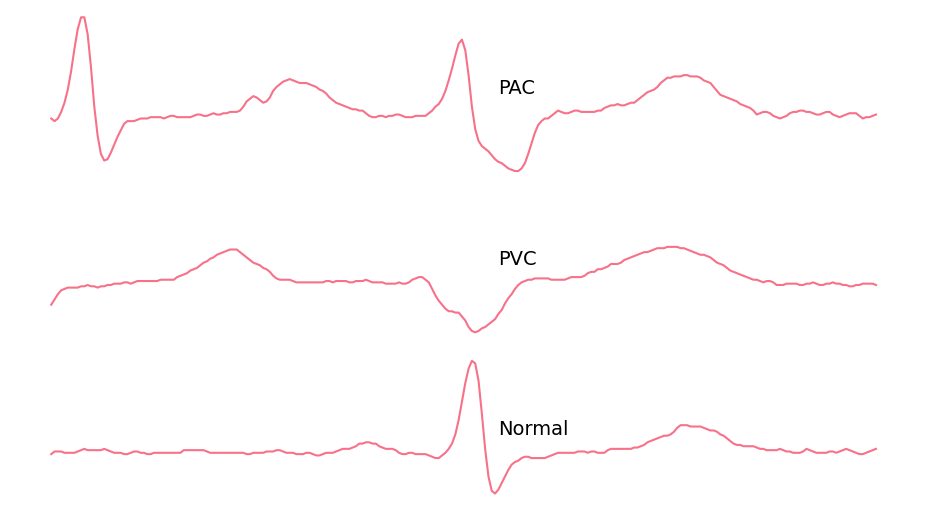

In [32]:
custom_texts = {
    'PAC': 'PAC',
    'PVC': 'PVC',
    'Normal': 'Normal'
}

palette = sns.color_palette("husl", len(values['annotation'].unique()))
g = sns.FacetGrid(values, row="annotation", aspect=5, height=2, despine=False, palette=palette)
g.map_dataframe(sns.lineplot, x="index", y="signal", hue="annotation", palette=palette)

for ax, annotation in zip(g.axes.flatten(), custom_texts.keys()):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(left=False, bottom=False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_title('')
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    x_position = 135
    y_position = values[values['annotation'] == annotation]['signal'].mean() + 0.2
    ax.text(x_position, y_position, custom_texts[annotation], verticalalignment='center', fontsize=14)
    
g.fig.subplots_adjust(hspace=0)

g.savefig('./media/data.png', dpi=300, bbox_inches="tight")
plt.show()

In [33]:
import torch
from io import BytesIO
from autoencoder import AE
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [34]:
data = np.load("../src/federated/weights/round-250-weights.npz", allow_pickle=True)
parameters_serialized = data['arr_0'].item()
pretrained_weights = [np.load(BytesIO(tensor), allow_pickle=False) for tensor in parameters_serialized.tensors]x

In [35]:
model = AE()
with torch.no_grad():
    for k, name in enumerate(model.named_parameters()):
        if k % 2 == 0:
            param = name[1]
            #print(param.shape)
            #print(pretrained_weights[int(k/2)].shape)
            param.copy_(torch.from_numpy(pretrained_weights[int(k/2)]))

In [36]:
def f(val, dim):
    a = [8.160960,2.347583,9.026686,3.429941,5.890089,-5.662026,0.545231,-4.219695,-2.919463,-8.039228,6.781175,1.928730]
    #my_tensor = torch.tensor(np.ones(12), dtype=torch.float32)
    my_tensor = torch.tensor(a, dtype=torch.float32)
    my_tensor[dim] = val
    plt.plot(model.decoder(my_tensor).detach().numpy())

In [37]:
floatSlider = widgets.FloatSlider(min=-10, max=10, step=0.1, value=0)

In [38]:
interact(f, val=floatSlider, dim=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=0.0, description='val', max=10.0, min=-10.0), Dropdown(description='di…

<function __main__.f(val, dim)>

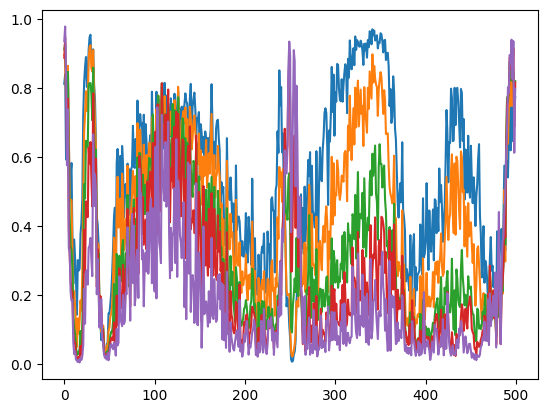

In [39]:
a = [8.160960,2.347583,9.026686,3.429941,5.890089,-5.662026,0.545231,-4.219695,-2.919463,-8.039228,6.781175,1.928730]
my_tensor = torch.tensor(a, dtype=torch.float32)
u = 9
for k in range(u,(u+1)):
    for j in np.linspace(-10, 10, 5):
        my_tensor[k] = j
        plt.plot(model.decoder(my_tensor).detach().numpy())

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

In [27]:
df_plot = pd.read_csv("./sample/p03984_24.csv")

In [28]:
index_pac = df_plot[df_plot.annotation == "pac"].index
index_pvc = df_plot[df_plot.annotation == "pvc"].index
index_normal = df_plot[df_plot.annotation == "normal"].index

In [29]:
values_pac = df_plot.iloc[(index_pac[2]-125):(index_pac[2]+125), 0].reset_index(drop=True).reset_index()
values_pvc = df_plot.iloc[(index_pvc[2]-125):(index_pvc[2]+125), 0].reset_index(drop=True).reset_index()
values_normal = df_plot.iloc[(index_normal[2]-125):(index_normal[2]+125), 0].reset_index(drop=True).reset_index()

In [30]:
values_pac["annotation"] = "PAC"
values_pvc["annotation"] = "PVC"
values_normal["annotation"] = "Normal"

In [31]:
values = pd.concat([values_pac, values_pvc, values_normal])

/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)
/opt/homebrew/anaconda3/envs/flwr/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  func(*plot_args, **plot_kwargs)


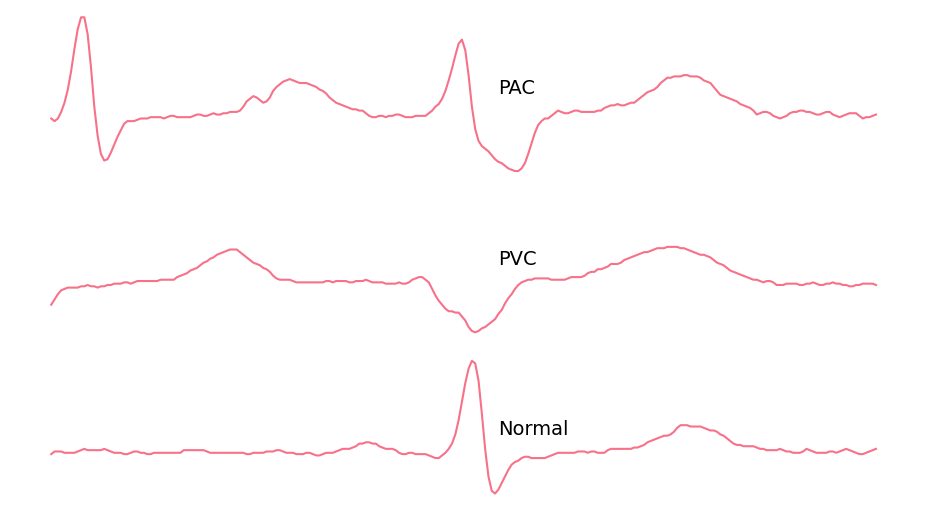

In [32]:
custom_texts = {
    'PAC': 'PAC',
    'PVC': 'PVC',
    'Normal': 'Normal'
}

# Create the FacetGrid with unique colors for each annotation
palette = sns.color_palette("husl", len(values['annotation'].unique()))
g = sns.FacetGrid(values, row="annotation", aspect=5, height=2, despine=False, palette=palette)
g.map_dataframe(sns.lineplot, x="index", y="signal", hue="annotation", palette=palette)

# Remove the y-axis, x-axis, annotation labels, and bounding box
for ax, annotation in zip(g.axes.flatten(), custom_texts.keys()):
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(left=False, bottom=False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.set_title('')
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    x_position = 135
    y_position = values[values['annotation'] == annotation]['signal'].mean() + 0.2
    ax.text(x_position, y_position, custom_texts[annotation], verticalalignment='center', fontsize=14)
    
g.fig.subplots_adjust(hspace=0)

g.savefig('./media/data.png', dpi=300, bbox_inches="tight")
plt.show()